In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/tf/ProjectGabriel/pilca")

import numpy as np
import pandas as pd
from lightcurve_fitting import models, lightcurve
from lightcurve_fitting import filters as flc
import matplotlib.pyplot as plt
import matplotlib as mpl
import importlib
from utils.utils import load_lc
from utils.utils import light_curve_plot
import torch
import utils.torchphysics as tp
import utils.utils as ut
import utils.analysis as an
# import lc
import os
torch.set_default_dtype(torch.float64)



In [2]:
all_filters = ["y", "z",  "i", "r", "g", "u"][::-1]#[-2:]  # from red to UV
mjd_array = np.linspace(3, 15, 100)

filter_combinations = [all_filters[:i+1] for i in range(len(all_filters))]

max_days = 12
time_spans = np.arange(1, max_days + 1)  # [1, 2, ..., 10]

model_parameters = [.35, 2., .2, 4.0, 2.5]

# --- setup light curve builder ---
builder = ut.LCBuilder(
    model_name="sc4",
    model_parameters=model_parameters,
    model_units=[1,1,1,1,1],
    seed=42)

lc = builder.build_sim_lc(
    mjd_array=mjd_array,
    filters_list=all_filters,  # full set
    redshift=0.00526,
    dlum_factor=1e-1/2,
    dm=31.1,
    dL=19.,
    dLerr=2.9
)

In [3]:
ten13cmtoRsol = 1e13*1.4374e-11
ten8p5cmstoten3kms = 10**.5

In [4]:
580/ten13cmtoRsol

4.035063308751913

In [5]:
model = models.ModifiedShockCooling4(lc)
model.t_max(model_parameters)

16.382471744387402

In [6]:
def get_filter_mask(lc, filters):
    filter_objects = [flc.filtdict[f] for f in filters]
    fmask = np.in1d(lc["filter"].value, filter_objects)
    return fmask

lc_subset = lc.where(MJD_max=lc["MJD"].min() + max_days)
lc_subset = lc_subset[get_filter_mask(lc_subset, filter_combinations[-1])]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torchenizer = tp.Torchenizer(lc_subset, ycol="loglum", device=device)

X_DATA, filters_mask, ufilters = torchenizer.get_xdata(max_phase=max_days, t0_offset=3)

Using device: cuda


In [7]:
nn_model_name = "bnn_pilca_early_stop_ugri_5d.pth"
model_save_dir = os.path.join(ut.storage_parent_path, "models", nn_model_name)

nn_model = tp.MultiFilterBNN(x_data=X_DATA,
                            filters_mask=filters_mask,
                            param_dim=5,
                            hidden_dim=16,
                            n_filter_layers=2,
                            n_combined_layers=2,
                            dropout_rate=0.).to(device)

criterion = tp.ModifiedSC4Loss(ufilters=ufilters,
                               z=lc.meta["redshift"],
                               mode="mean_param",
                               min_t0=torch.min(X_DATA[:,0])-1e-5,
                               fixed_frhom=builder.model_parameters[2])
lr=1e-2
optimizer = torch.optim.Adam(nn_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=150, gamma=0.5)

trainer = tp.Trainer(model=nn_model,
                    criterion=criterion,
                    epochs=2000,
                    n_samples_loss=100,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    verbose_step=1,
                    save_dir=model_save_dir,
                    es_kwargs={"use_es":True,
                               "patience":200,
                               "save_best_loss":True},
                    change_loss=False)

history = trainer.train()

--- Step 0 ---
Shock velocity (v_s):     5.0639
Envelope mass (M_env):    5.0451
Density factor (f_rho_M): 4.7253
Radius (R):               5.0348
Explosion time (t_exp):   4.7423
Loss:                     4.612238
----------------------------------------
--- Step 1 ---
Shock velocity (v_s):     4.7634
Envelope mass (M_env):    4.9543
Density factor (f_rho_M): 4.5131
Radius (R):               4.8409
Explosion time (t_exp):   4.7422
Loss:                     4.369073
----------------------------------------
--- Step 2 ---
Shock velocity (v_s):     4.3294
Envelope mass (M_env):    5.1559
Density factor (f_rho_M): 4.1412
Radius (R):               4.2376
Explosion time (t_exp):   4.5614
Loss:                     3.942695
----------------------------------------
--- Step 3 ---
Shock velocity (v_s):     3.5362
Envelope mass (M_env):    5.5649
Density factor (f_rho_M): 3.3281
Radius (R):               3.1939
Explosion time (t_exp):   4.1146
Loss:                     3.086818
-----------------

KeyboardInterrupt: 

In [8]:
torch.mean(X_DATA[:,2])

tensor(0.0195, device='cuda:0')

In [9]:
samples = []
for i in range(1000):
    samples.append(nn_model())
samples = torch.stack(samples).detach().cpu().numpy() # shape [N_samples, 5]

print(samples.shape)


(1000, 5)


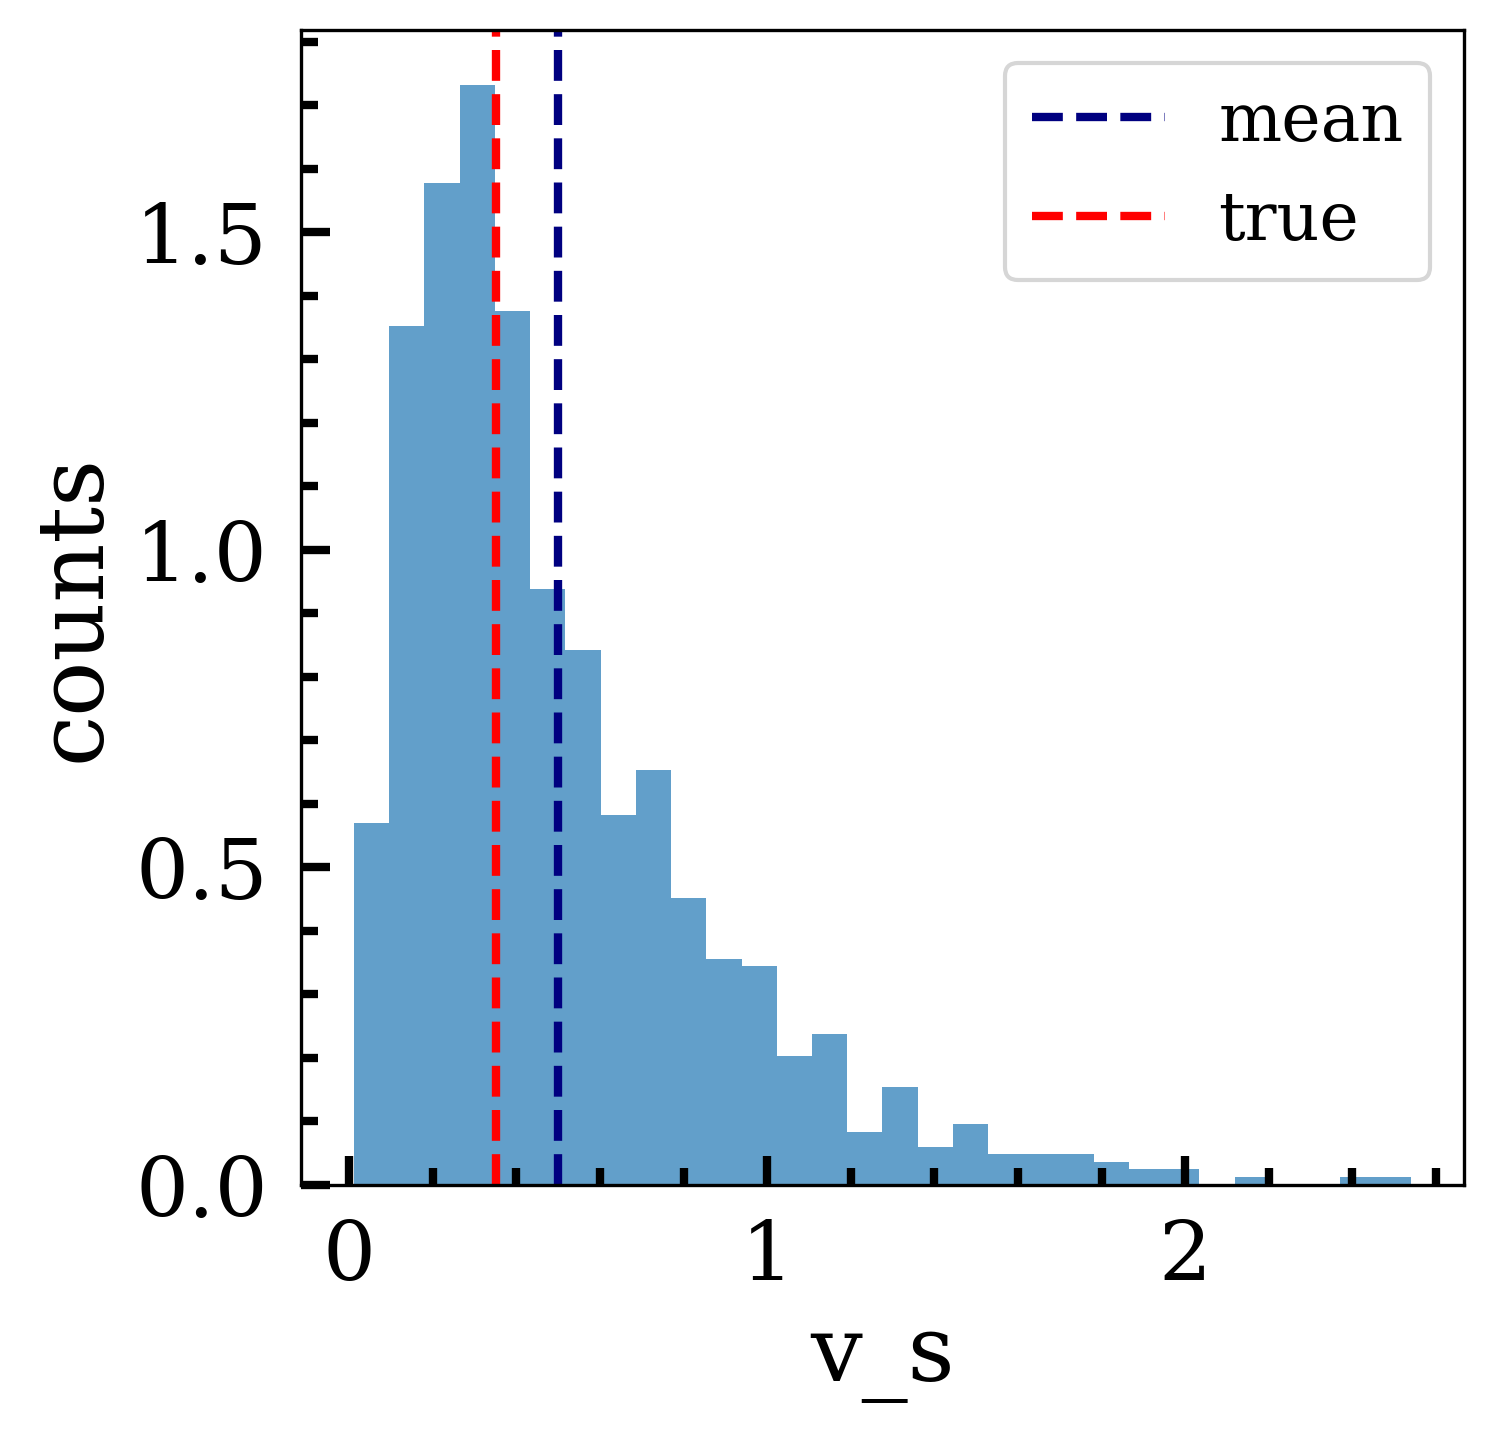

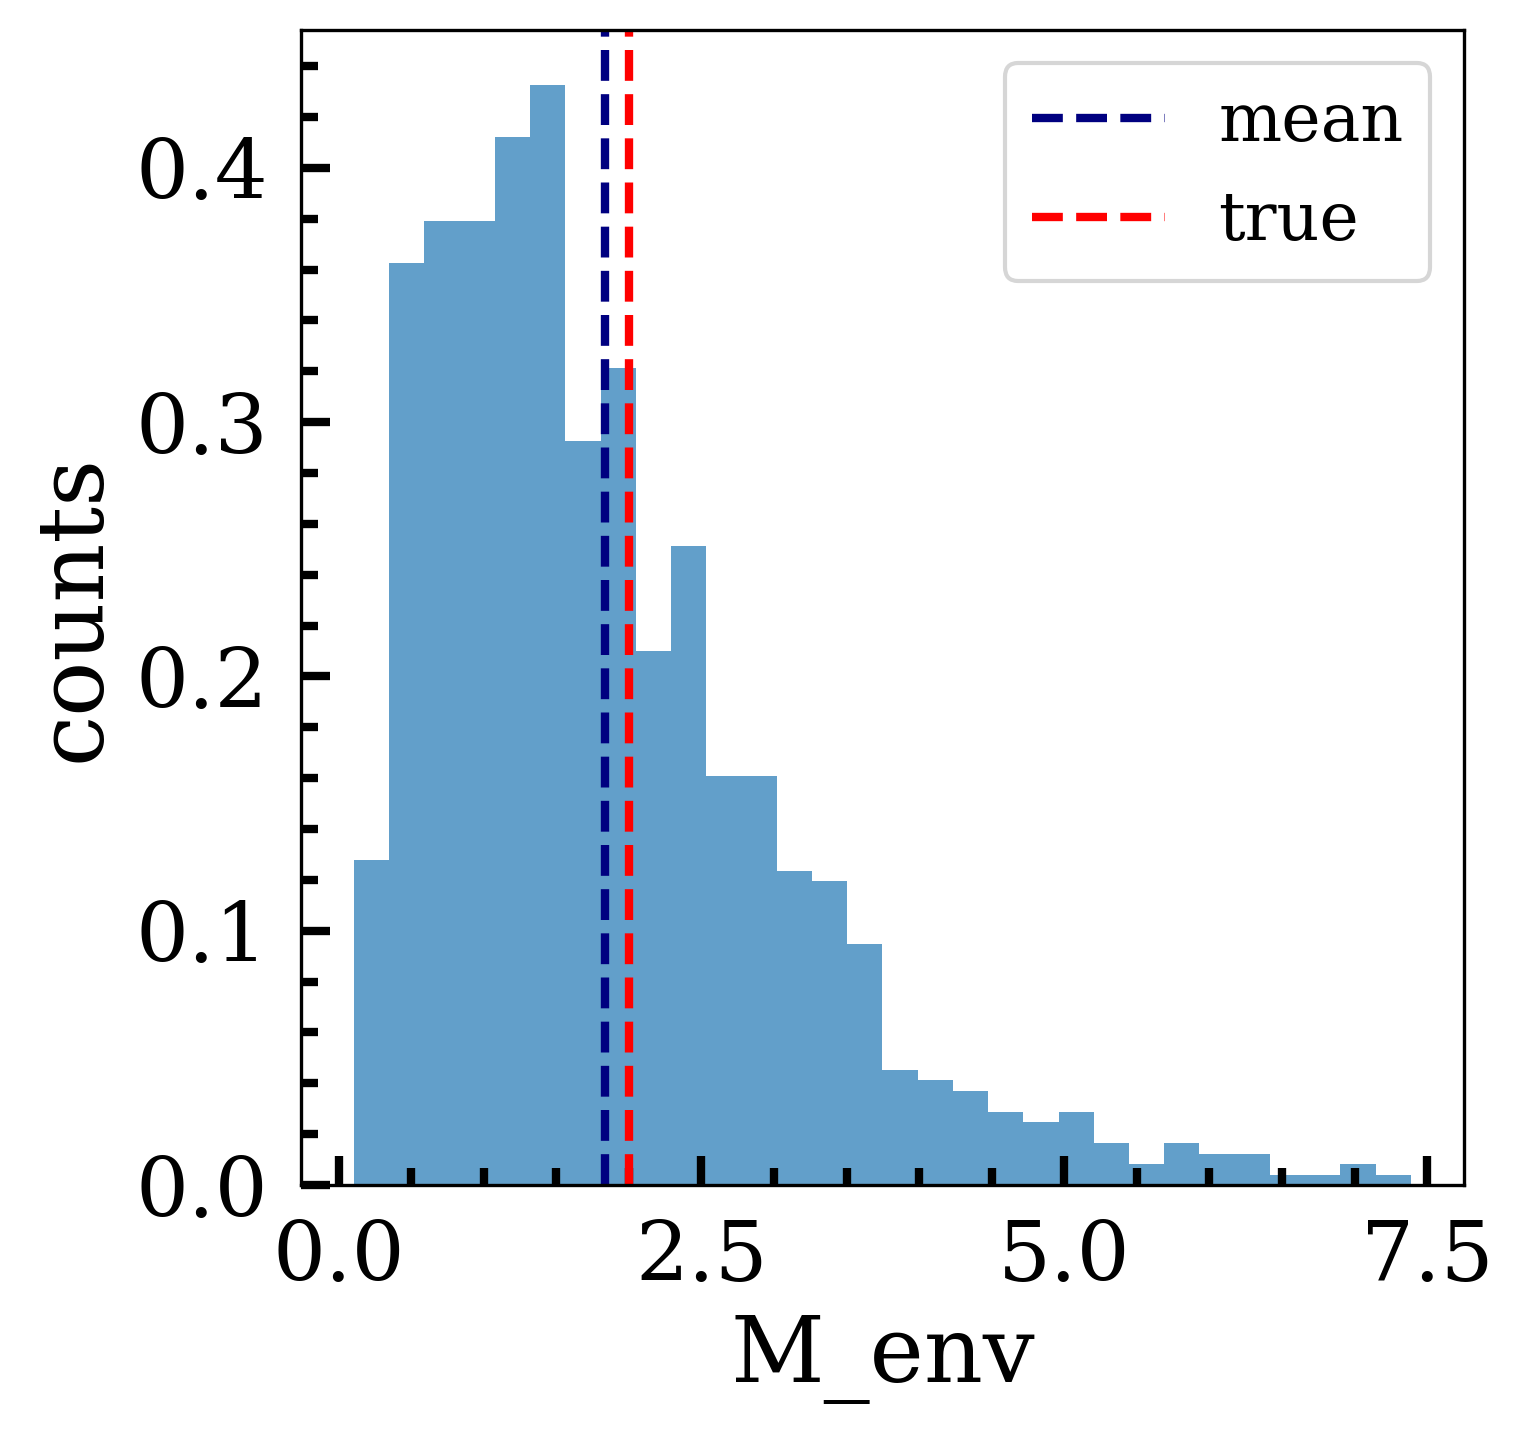

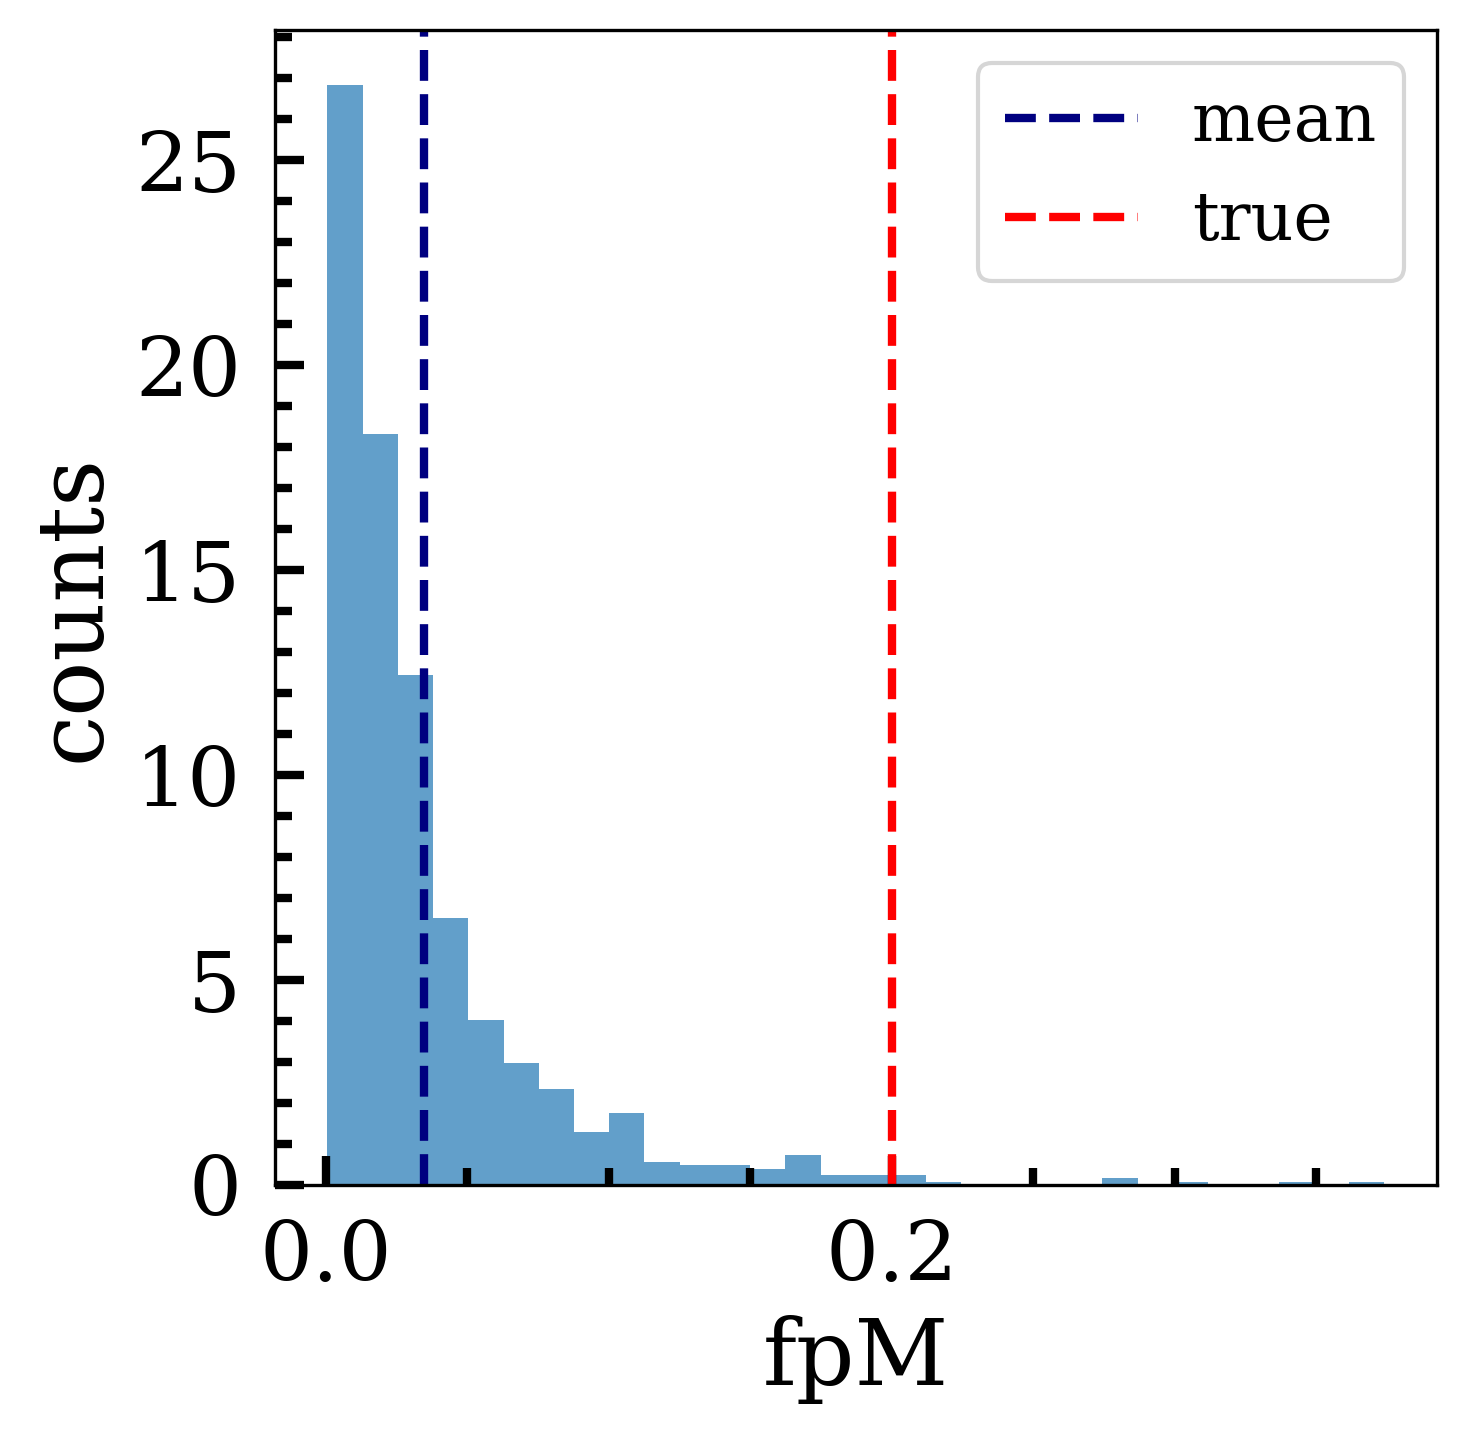

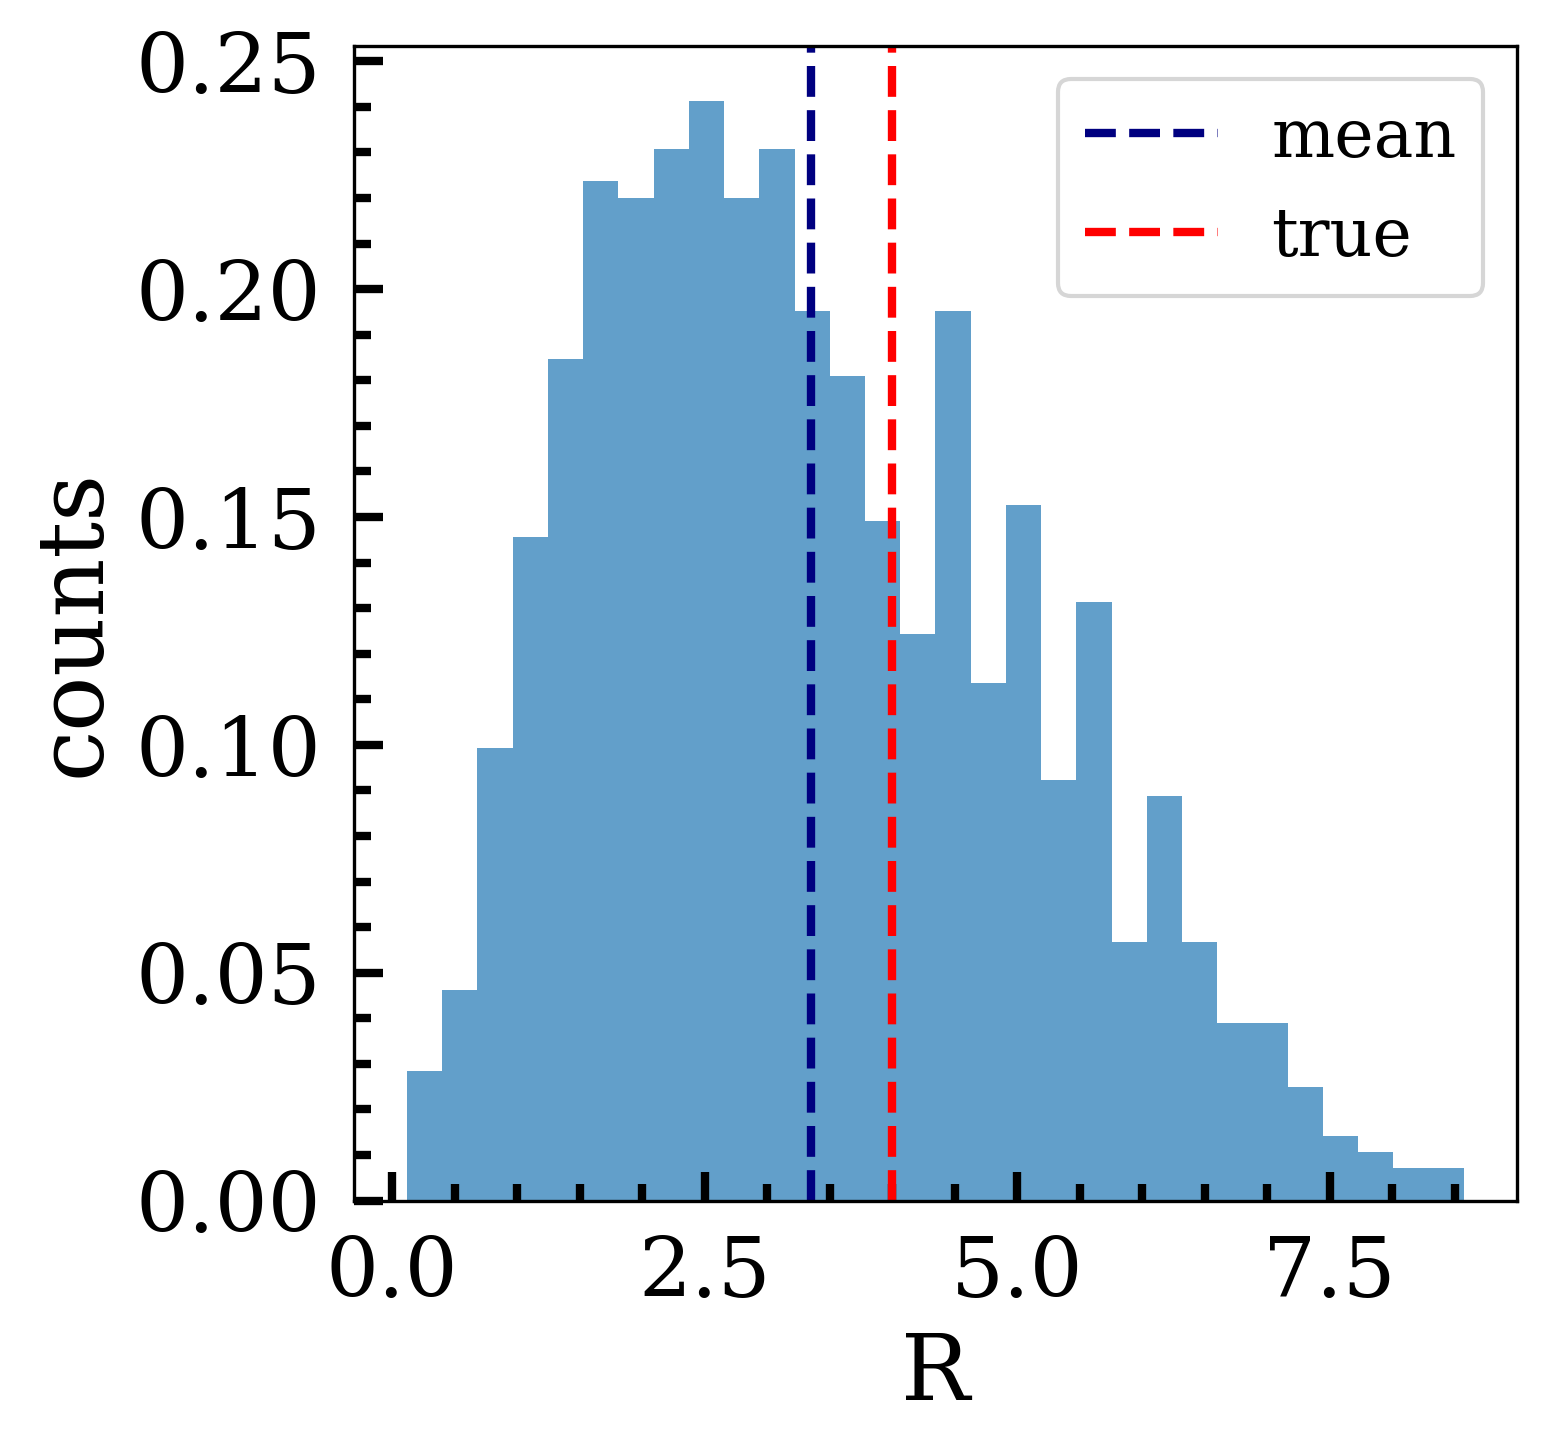

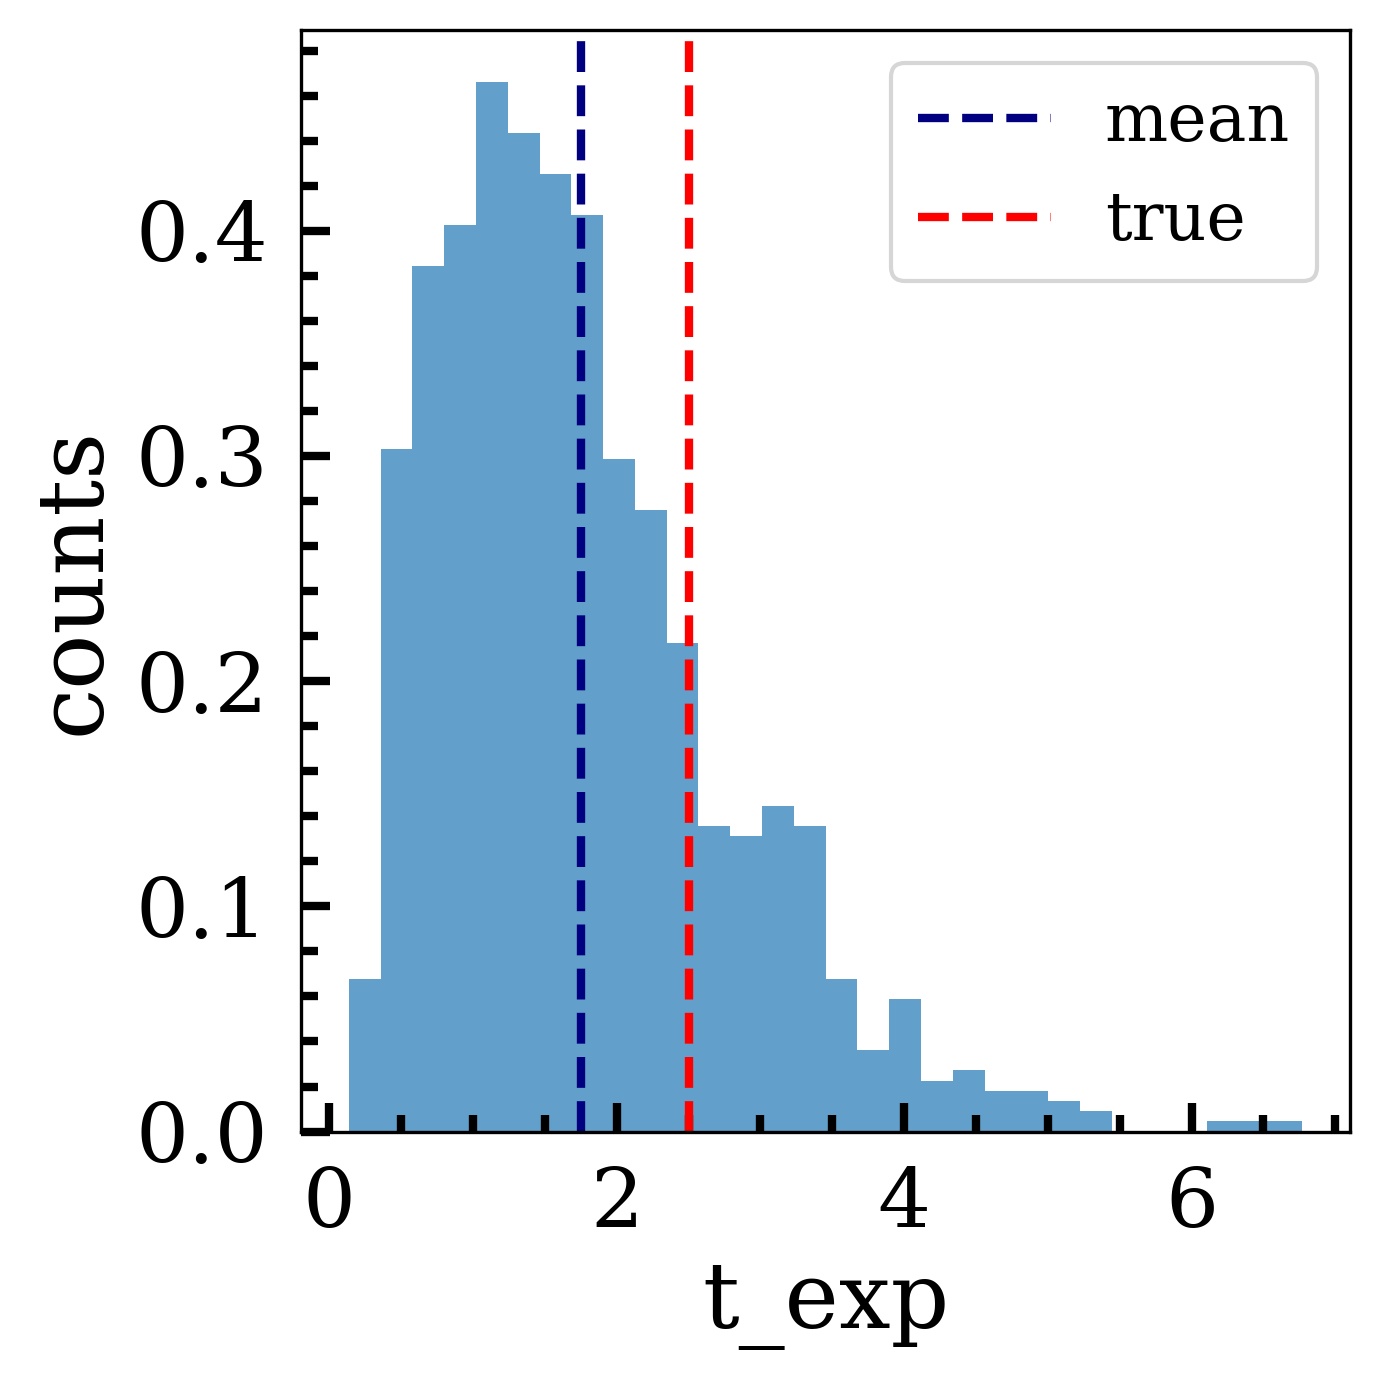

In [10]:
import utils.paper_plot_style as pps
pps.set_plot_style()

param_names = ["v_s", "M_env","fpM",  "R", "t_exp"]
mean = samples.mean(0)
std = samples.std(0)
true = builder.model_parameters
# fig, axes = plt.subplots(1, 5, figsize=(30, 5), dpi=300)
for i, name in enumerate(param_names):
    fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
    axes.hist(samples[:, i], bins=30, density=True, color="tab:blue", alpha=0.7)
    axes.axvline(mean[i], color="navy", linestyle="--", label="mean", lw=2)
    axes.axvline(true[i], color="red", linestyle="--", label="true", lw=2)


    axes.set_xlabel(name)
    axes.set_ylabel("counts")
    axes.legend()

plt.tight_layout()
plt.show()

In [11]:
(np.array(samples.mean(0) - model_parameters) )/np.array(model_parameters)

array([ 0.4284348 , -0.08131307, -0.8256569 , -0.16129665, -0.29903132])

In [12]:
samples.mean(0)

array([0.49995218, 1.83737386, 0.03486862, 3.35481339, 1.75242169])

/tf/ProjectGabriel/pilca/utils/analysis.py:68: RuntimeWarning: divide by zero encountered in log10
  ax.plot(t_grid, np.log10(mod_vals.squeeze()) + offsets[filt], color=filtstyle["color"], alpha=0.05, zorder=0)


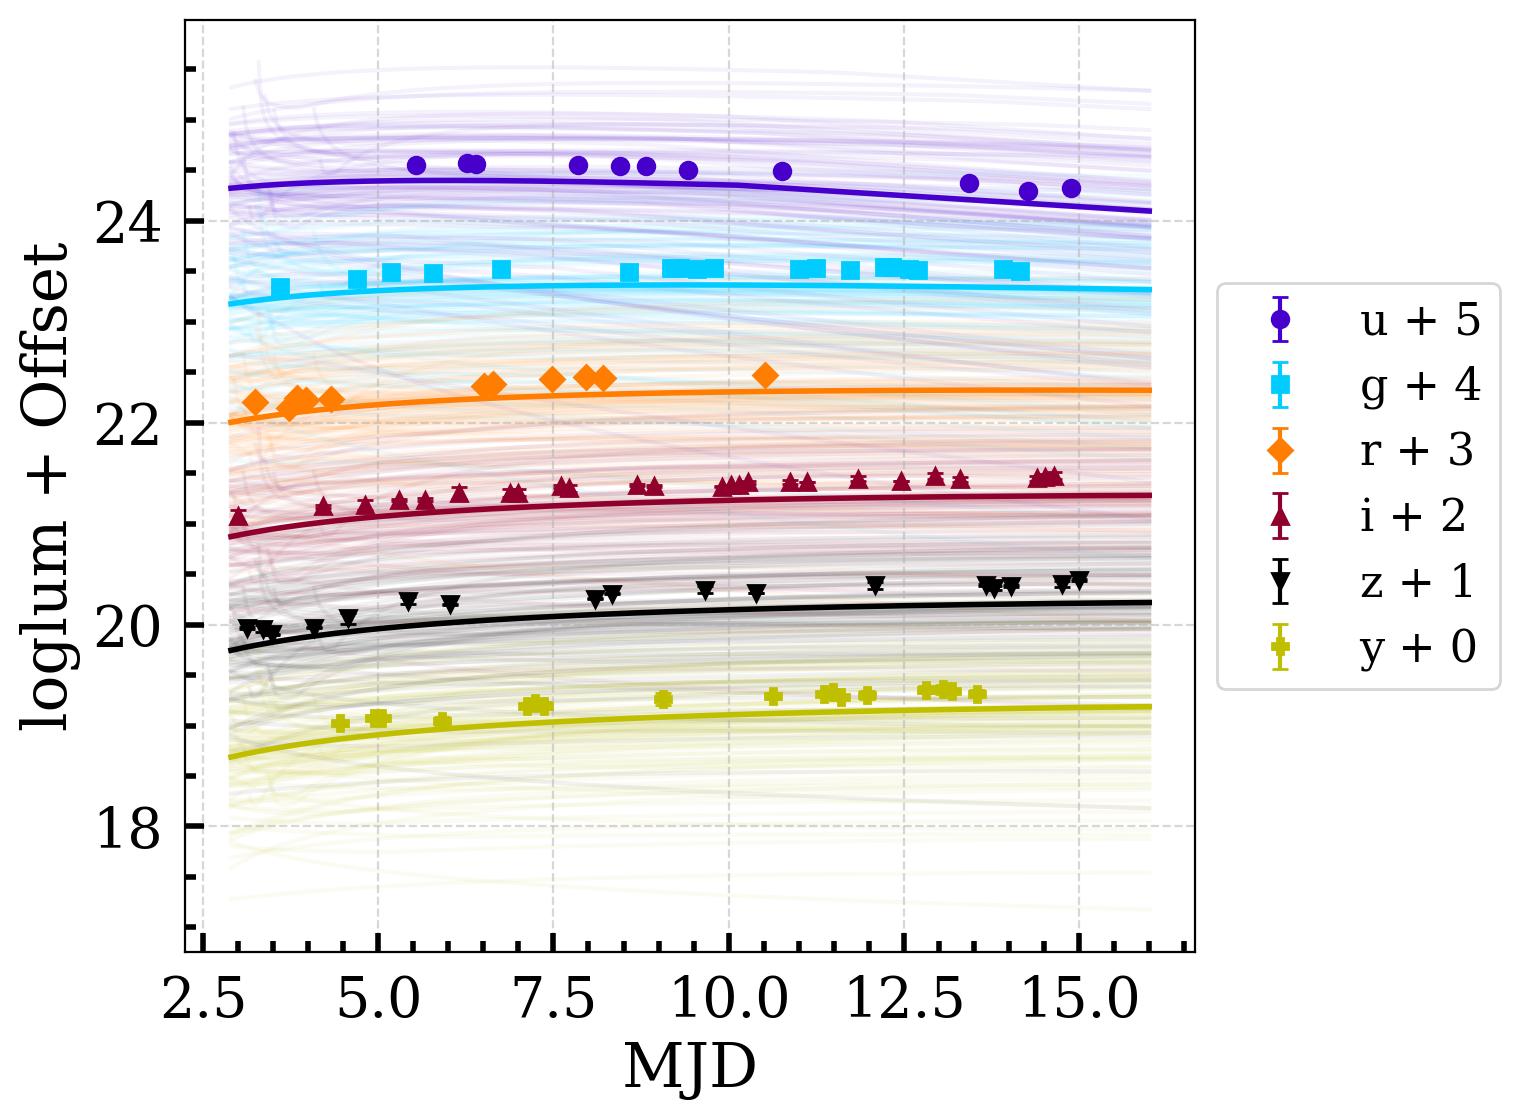

In [13]:
model = models.ModifiedShockCooling4(lc)
an.lc_modeling_plot(lc=lc, samples=samples, model=model, ycol="loglum", offset=1)

(0.0, 0.1)

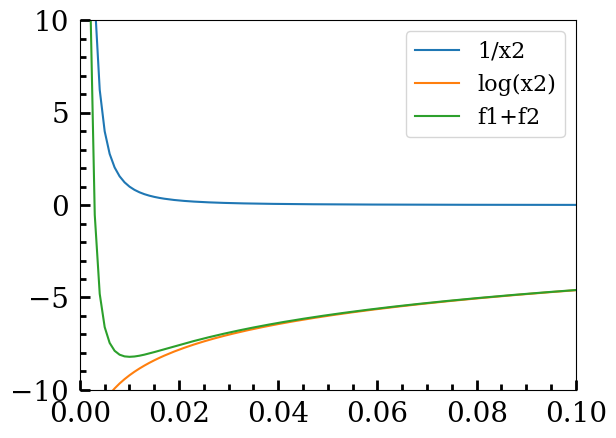

In [ ]:
x  = np.linspace(1e-8, 1, 1000)
f1 = lambda x: 1e-4/x**2
f2 = lambda x: np.log(x**2)

plt.plot(x, f1(x), label="1/x2")
plt.plot(x, f2(x), label="log(x2)")
plt.plot(x, f1(x)+f2(x), label="f1+f2")
plt.legend()
plt.ylim(-10,10)
plt.xlim(-0,1e-1)
